# Filtering the probes generated using VisDial dialogues

The script `main.py` manipulates QA pairs from VisDial dialogues and turn them into propositions/probes. The files are saved in `propositions/original/propositions_{set}.json`. 

However, two post-processing steps are necessary to improve the datasets before they are used for the classification tasks:

- the proportion of caption probes in relation to other turns is too much higher, thus we sample them to make the distribution closer to uniform among turns.
- to make sure the training set has no bias with respect to the True/False dimension, we also downsample it to enforce that, for every true probe, a false counterpart of the same type is included.

In [1]:
import json
import csv
import copy
import random
import matplotlib.pyplot as plt

from collections import Counter
from pathlib import Path
from IPython.display import Image

In [2]:
PATH_TO_PROBES = 'propositions/'

In [3]:
random.seed(2204)

# Downsampling captions and removing `how_many` rule

When we first run the `analysis_generated_probes` notebook, we notice that many more caption probes are generated, making turn_shared=0 being manipulated too often in comparison to the other turns.

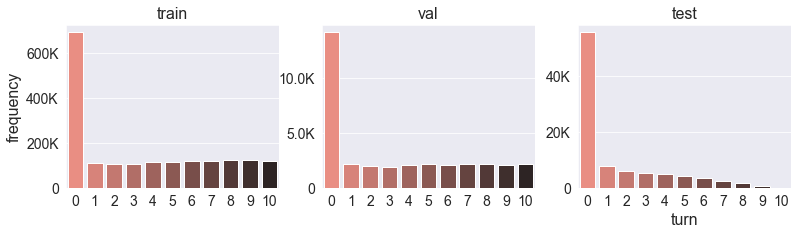

In [4]:
Image(filename='propositions/original-propositions_turn-distribution.png') 

So we begin by downsampling caption probes so that the final distribution is roughly uniform among turns.

In [5]:
CAPTION_PROPORTION = 0.15  # select a small number

In [6]:
propositions = {}

with open(PATH_TO_PROBES + 'original/propositions_train.json', 'r') as data:
    propositions['train'] = json.load(data)
with open(PATH_TO_PROBES + 'original/propositions_val.json', 'r') as data:
    propositions['val'] = json.load(data)
with open(PATH_TO_PROBES + 'original/propositions_test.json', 'r') as data:
    propositions['test'] = json.load(data)

We generated the human sample with a previous version of the propositions dataset, so we just make sure to include all datapoints in the test set again.

In [7]:
human_sample = []
eval_props = {}
eval_captions = {}

with open('propositions/human-results.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for username, _, _, dialog_id, _, prop_id, _, _, _, _, turn_shared, _, truefalse, *_, sentence in reader:
        if username == 'username':
            continue
        a_thinks_true = 1 if 'entailment' in truefalse else 0
        human_sample.append((int(dialog_id), int(turn_shared), a_thinks_true))
        eval_props[(int(dialog_id), int(turn_shared), a_thinks_true)] = sentence
        if turn_shared == '0':
            eval_captions[int(dialog_id)] = (prop_id, a_thinks_true, sentence)
        
assert len(human_sample) == 300
human_sample = set(human_sample)
assert len(human_sample) == 100
assert len(eval_props) == 100

The datapoints below (dialogues 639, 1447, 2807, 4718, 7683, 4327) derive from rules that can invert order (```what_color``` and ```image_in_color```). So we put them back into the order that was used in the sample.

In [8]:
need_readjust_order = [(639, 2, 1), (1477, 1, 1), (2897, 1, 1), (4718, 3, 1), (7683, 4, 1), (4327, 1, 0)]

def readjust_order(d_id, proposition):
    # some hacking to make sure that the original human datapoints are not excluded
    # because the new generation changed the order of the colors or the word picture/image
    # in the proposition, we replace them.
    turn_shared = proposition['turn_shared']
    a_thinks_true = proposition['a_thinks_true']
    sentence = proposition['proposition']
    
    if (d_id, turn_shared, a_thinks_true) == (639, 2, 1):
        assert set(sentence) == set('the train is green and yellow.')
        print(sentence)
        return 'the train is green and yellow.'
    
    if (d_id, turn_shared, a_thinks_true) == (1477, 1, 1):
        assert set(sentence) == set('the bus is white, green and blue.')
        print(sentence)
        return 'the bus is white, green and blue.'

    if (d_id, turn_shared, a_thinks_true) == (2897, 1, 1):
        assert set(sentence) == set('the plane is white and red.')
        print(sentence)
        return 'the plane is white and red.'
    
    if (d_id, turn_shared, a_thinks_true) == (4718, 3, 1):
        assert set(sentence) == set('the man wearing a bathrobe\'s robe is brown and orange.')
        print(sentence)
        return 'the man wearing a bathrobe\'s robe is brown and orange.'

    if (d_id, turn_shared, a_thinks_true) == (7683, 4, 1):
        assert set(sentence) == set('the wall is white and green.')
        print(sentence)
        return 'the wall is white and green.'
    
    if (d_id, turn_shared, a_thinks_true) == (4327, 1, 0):
        assert sentence in ['the picture is not in color.', 'the image is not in color.', 'the photo is not in color.']
        print(sentence)
        return 'the picture is not in color.'
    
    print('!!!')
    return None
    
def check_conditions(d, p, turn_shared, split, sentence):
    # we check the even indexes, because when we exclude a probe we exclude it's negated
    # counterpart as well, which is p+1, so that we keep the same pattern as the other
    # manupulation rules (all probes appear with its negation in the sets)
    if int(p) % 2 == 0 and turn_shared == 0:
        if split != 'test':
            return True
        # in the captions, we are sure that the order of p (should not have) did not change...
        # coref is not used for the captions and the Spacy version should be the same.
        # in any case, this will be enforced/checked in the next steps
        elif d not in eval_captions:
            return True
        else:
            # do not sample out a caption that occurred in the humal results, or its counterpart.
            prop_id = int(eval_captions[d][0])
            if p != prop_id and p+1 != prop_id: 
                return True   
        return False


In [9]:
downsampled_captions = copy.deepcopy(propositions)

for split in ('train', 'val', 'test'):
    for d, dialogue in propositions[split]['dialogues'].items():   
        for p, proposition in dialogue.items():

            turn_shared = int(proposition['turn_shared'])
            a_thinks_true = int(proposition['a_thinks_true'])
            
            if split == 'test' and (int(d), turn_shared, a_thinks_true) in need_readjust_order:
                downsampled_captions[split]['dialogues'][d][p]['proposition'] = readjust_order(int(d), proposition)
           
            elif check_conditions(int(d), int(p), turn_shared, split, proposition['proposition']):
                if random.random() > CAPTION_PROPORTION:
                    del downsampled_captions[split]['dialogues'][d][p]
                    del downsampled_captions[split]['dialogues'][d][str(int(p)+1)]

for split in ('train', 'val', 'test'):
    with open(PATH_TO_PROBES + '/downsampled-propositions_'+split+'.json', 'w') as f:
        json.dump(downsampled_captions[split], f)

the train is green and yellow.
the bus is white, green and blue.
the plane is white and red.
the photo is not in color.
the man wearing a bathrobe's robe is orange and brown.
the wall is white and green.


Make sure that all datapoints in the human sample. The sample has 100 datapoints, but we'll exclude 3 how_many and 1 that was filtered out (contained word fat), so it must be 96.

In [10]:
split = 'test'
check = set()
for (d, turn_shared, a_thinks_true) in human_sample:
    all_props = set([prop['proposition'] for p, prop in downsampled_captions[split]['dialogues'][str(d)].items()])
    if eval_props[(d, turn_shared, a_thinks_true)].lower() not in all_props:# and d not in ('639', '1477', '4327'):
        print(d, turn_shared, eval_props[(d, turn_shared, a_thinks_true)].lower())
        check.add(d)

7417 3 one cannot see any what the 3're looking at.
14 3 there is no water coming off from it.
7054 6 the photo is in a house.
1310 2 there is a person.
6447 1 there are no elephants.


In [11]:
print(f'The missing dialogues are: {check}.')

The missing dialogues are: {7054, 6447, 14, 7417, 1310}.


In total, 6 datapoints must be ignored in the human results sample.

Another problem that showed up later: the `how_many` as is implemented rule breaks our assumptions. We have removed them during generation instead.

- (798, 1, false): how_many, was excluded
- (6447, 1, false): how_many, was excluded
- (1310, 2, true): how_many, was excluded

(7347, 2, false): dialogue would be filtered out, but I put it back in the sample

Three changed due to the new coref resolution:
- (14, 3, 1): 'there is no water coming off from it.' is now 'there is no water coming off from the red fire hydrant.'
- (7054, 6, 0): 'the photo is in a house.' is now 'the old fashioned motorcycle is in a house.'
- (7417, 3, 1): "One cannot see any what the 3're looking at." is now "one cannot see any what the kids're looking at."

For captions, we can (supposedly) rely on the proposition ID. Coref resolution is not used when generating caption propositions and the rules did not change. By using the same Spacy version, nothing should change. For the remaining rules, the prop_id is not reliable because by removing the ```how_many``` rule and with the new coref model, besides other small adjustments in the rules (```look_like```), their order may have changed. What persists is the triplet (dialogue_id, turn_shared, a_thinks_true).

In [12]:
split = 'test'
check = set()
for (d, turn_shared, a_thinks_true) in human_sample:
    if turn_shared == 0:
        (prop_id, _, sentence) = eval_captions[d]
        assert sentence.lower() == downsampled_captions[split]['dialogues'][str(d)][prop_id]['proposition']
        #print(sentence.lower())
        #print(downsampled_captions[split]['dialogues'][str(d)][prop_id]['proposition'])
        #print('\n')
    elif d in (14, 1310, 7054, 7417, 798, 6447):
        # these were excluded
        continue
    else:
        sentence = eval_props[(d, turn_shared, a_thinks_true)]
        props_list = downsampled_captions[split]['dialogues'][str(d)]
        item = [prop for idx, prop in props_list.items() if prop['turn_shared'] == turn_shared and prop['a_thinks_true'] == a_thinks_true]
        assert sentence.lower() == item[0]['proposition']
        #print(sentence.lower())
        #print(item[0]['proposition'])
        #print('\n')

# Making the training set balanced

Some probes/rules may occur more often as true/false, and that would introduce bias on the main task. In order to avoid this true/false bias in the training probes, we manufacture a training set that, for each true probe included, a false counterpart with the same surface form is included (i.e. if 'it is sunny' is included wrt an image+dialogue where it is true, we for sure include another 'it is sunny' probe paired with an image+dialogue that makes it false).

In [13]:
random.seed(2204)

Select a maximum to clip and avoid probes that occur too often:

In [14]:
CLIP = 1000

In [15]:
path_props = Path(PATH_TO_PROBES, 'downsampled-propositions_train.json')
with open(path_props, 'r') as f:
    props_data = json.load(f)

In [16]:
probe_sentences = {}
for d_id, dialogue in props_data['dialogues'].items():
    for p_id, prop in dialogue.items():
        sent = prop['proposition']
        if sent not in probe_sentences:
            probe_sentences[sent] = {'true':[], 'false':[]}
        status = 'true' if prop['a_thinks_true'] == 1 else 'false'
        probe_sentences[sent][status].append((d_id, p_id))

In [17]:
usable = [s for s in probe_sentences.keys() if len(probe_sentences[s]['true']) > 0 and len(probe_sentences[s]['false']) > 0]

In [18]:
print(f'Number of probe types that occur both as true and false: {len(usable)}.')

Number of probe types that occur both as true and false: 27011.


In [19]:
sample = {s: {'true': [], 'false': []} for s in usable}
datapoints = []

freqs = Counter()

for s, occurrences in probe_sentences.items():
    
    n = min(len(occurrences['true']), len(occurrences['false']))
    n = min(n, CLIP) # select a maximum to clip
    if n == 0:
        continue
    selected_true = random.sample(probe_sentences[s]['true'], n)
    selected_false = random.sample(probe_sentences[s]['false'], n)
    
    sample[s]['true'].append(selected_true)
    sample[s]['false'].append(selected_false)
    
    datapoints += selected_true
    datapoints += selected_false
    
    freqs.update({s: n*2})

In [20]:
print(f'Size of the new training set will be: {sum(freqs.values())}')

Size of the new training set will be: 344988


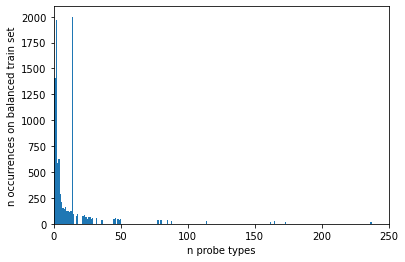

In [21]:
freq_probes = Counter(freqs.values())
plt.bar(freq_probes.values(), freq_probes.keys(), width=1)
#plt.ylim(0, 100)
plt.xlabel('n probe types')
plt.ylabel('n occurrences on balanced train set')
plt.xlim(0,250)
plt.show()

Example:

In [22]:
sample['there is a dog.']['true']

[[('84071', '8'),
  ('3128', '0'),
  ('13995', '2'),
  ('12903', '4'),
  ('44601', '2'),
  ('48751', '4'),
  ('90219', '8'),
  ('30533', '0'),
  ('8172', '4'),
  ('47368', '2'),
  ('58530', '4'),
  ('27000', '0'),
  ('117003', '2'),
  ('82759', '2'),
  ('108504', '0'),
  ('15574', '8'),
  ('106739', '0'),
  ('69724', '6'),
  ('99157', '0'),
  ('40552', '0'),
  ('4845', '0'),
  ('4221', '4'),
  ('5076', '2'),
  ('123212', '2'),
  ('75545', '2'),
  ('60358', '0'),
  ('51897', '4'),
  ('57044', '0'),
  ('20611', '6'),
  ('27825', '6'),
  ('16253', '6'),
  ('46921', '6'),
  ('33097', '2'),
  ('32907', '0'),
  ('89652', '4'),
  ('89245', '2'),
  ('54156', '2'),
  ('58459', '2'),
  ('120526', '2'),
  ('96087', '4'),
  ('37463', '8'),
  ('45272', '2'),
  ('85770', '0'),
  ('23463', '0'),
  ('50013', '0'),
  ('21008', '6'),
  ('89090', '2'),
  ('11490', '2'),
  ('83248', '2'),
  ('101789', '4'),
  ('117571', '14'),
  ('16762', '2'),
  ('14060', '0'),
  ('10595', '0'),
  ('121027', '4'),
  ('84

In [23]:
sample['there is a dog.']['false']

[[('85183', '11'),
  ('85514', '23'),
  ('89756', '15'),
  ('94424', '7'),
  ('120892', '19'),
  ('121229', '21'),
  ('90066', '17'),
  ('108015', '13'),
  ('86738', '23'),
  ('118217', '15'),
  ('84122', '9'),
  ('92947', '11'),
  ('88304', '17'),
  ('118379', '23'),
  ('104002', '13'),
  ('68318', '13'),
  ('88598', '11'),
  ('98595', '13'),
  ('15072', '9'),
  ('86389', '7'),
  ('67211', '7'),
  ('122498', '13'),
  ('120684', '13'),
  ('119517', '17'),
  ('84587', '21'),
  ('20973', '13'),
  ('73204', '11'),
  ('94545', '11'),
  ('4512', '17'),
  ('90324', '11'),
  ('97093', '13'),
  ('13072', '7'),
  ('84042', '13'),
  ('82962', '23'),
  ('105421', '19'),
  ('117681', '19'),
  ('85457', '21'),
  ('96802', '21'),
  ('112458', '9'),
  ('114401', '5'),
  ('121488', '17'),
  ('14134', '11'),
  ('29604', '11'),
  ('29171', '9'),
  ('95797', '17'),
  ('120829', '11'),
  ('79967', '13'),
  ('53316', '11'),
  ('111491', '7'),
  ('28834', '17'),
  ('118128', '21'),
  ('83343', '11'),
  ('11

Saving as file:

In [24]:
props_data.keys()

dict_keys(['orig_data', 'set', 'dialogues'])

In [25]:
balanced_props = {'orig_data': props_data['orig_data'], 'set': props_data['set'], 
                  'dialogues':{str(x): {} for x in range(len(props_data['dialogues']))}}

for (d_id, p_id) in set(datapoints):
    prop = props_data['dialogues'][d_id][p_id]
    if d_id not in balanced_props['dialogues']:
        balanced_props['dialogues'][d_id] = {}
    balanced_props['dialogues'][d_id][p_id] = prop

In [26]:
n_samples = len([1 for d in balanced_props['dialogues'].values() for p in d])
print(n_samples)

344988


Number of training datapoints will be:

In [27]:
n_samples*11 # n_probes * 11 turns

3794868

Save the new training file:

In [28]:
with open(Path(PATH_TO_PROBES, 'downsampled-balanced-propositions_train.json'), 'w') as f:
    json.dump(balanced_props, f)